In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import string
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import pickle
import seaborn as sns
from collections import Counter
from sklearn.metrics import fbeta_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [2]:
## store the embeddings and one hot encodings using np.save()

In [3]:
X_train,y_train,X_test,y_test = np.load('embed_train.npy'),np.load('labels_train.npy'),np.load('embed_test.npy'),np.load('labels_test.npy')

In [4]:
alphabets = list(string.ascii_uppercase)

In [5]:
# store both the multi label binarizer models

In [6]:
with open('mlb.pkl','rb') as file:
    mlb = pickle.load(file)
with open('mlb_letter.pkl','rb') as file:
    mlb_letter = pickle.load(file)

In [7]:
#y_train_letter
y_labels_train = mlb.inverse_transform(y_train)
y_labels_test = mlb.inverse_transform(y_test)

In [8]:
y_starter_train = [tuple(s[0] for s in tup) for tup in y_labels_train]
y_starter_test = [tuple(s[0] for s in tup) for tup in y_labels_test]

In [9]:
y_train_letter = mlb_letter.transform(y_starter_train)
y_test_letter = mlb_letter.transform(y_starter_test)

In [10]:
gc.collect()

0

In [137]:
# find the number of labels in each label
final_length = np.sum(y_train,axis = 1)   #captures number of final labels assigned to each instance

letter_length = np.sum(y_train_letter,axis = 1) # captures number of letters assigned to each instance

print(Counter(final_length))

print(Counter(letter_length))

Counter({1: 17151, 2: 10874, 3: 5533, 4: 2843, 5: 1446, 6: 743, 7: 345, 8: 158, 9: 79, 10: 39, 11: 22, 12: 12, 14: 6, 13: 4, 16: 2, 15: 1})
Counter({1: 25959, 2: 10335, 3: 2572, 4: 349, 5: 39, 6: 4})


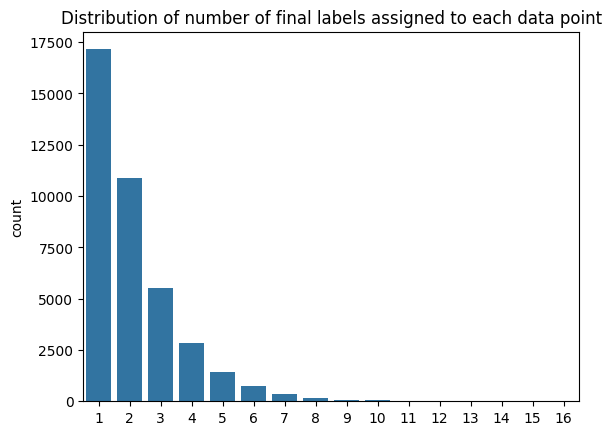

In [138]:
sns.countplot(x = final_length)
plt.title('Distribution of number of final labels assigned to each data point')
plt.show()

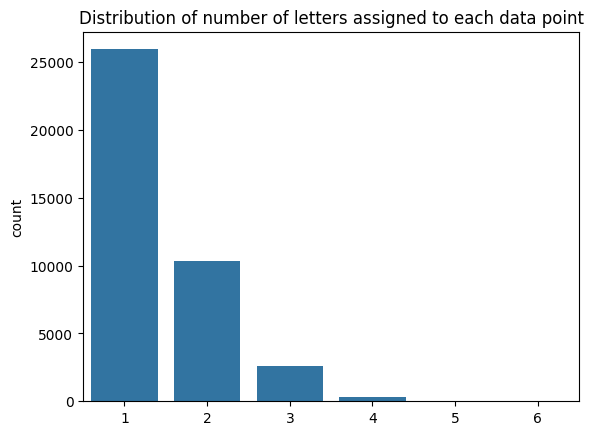

In [139]:
sns.countplot(x = letter_length)
plt.title('Distribution of number of letters assigned to each data point')
plt.show()

Conclusion is that you can go for clusters with 3 representatives to figure out most of the data

In [142]:
# Clustering on label_space
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(y_train_letter)

means = kmeans.cluster_centers_

# iterating through the observed means and making top 3 values 1 and the rest 0. Btw means cannot exceed 1
for i,mean in enumerate(means):
    indices = np.argsort(mean)[-3:]
    means[i,indices] = 1 

means[np.where(means!=1)] = 0

means_map = dict([(ind,mean) for ind,mean in enumerate(means)])  #map which maps the one hot encoding of the mean representatives to its cluster index

In [143]:
clusters = Counter(mlb_letter.inverse_transform(means)).keys()
print(clusters)
print(len(set(clusters)))

dict_keys([('F', 'K', 'R'), ('H', 'T', 'Z'), ('G', 'H', 'J'), ('D', 'N', 'R'), ('D', 'K', 'Z'), ('G', 'M', 'S'), ('N', 'R', 'Z'), ('K', 'R', 'Z'), ('C', 'N', 'Z'), ('E', 'L', 'Z')])
10


In [153]:
y_train_cluster = np.array([means_map[ind] for ind in kmeans.predict(y_train_letter)]) #assigning representatives

In [155]:
mlabels = mlb.classes_

letter_presence = np.zeros_like(y_train_letter) 
#for any instance if value is 1, that means the data point has atleast one final label starting with this letter

i = 0
for letter in alphabets:
    if letter == 'P' or letter == 'U':
        continue
    #getting all indices of labels starting with 'letter'
    indices = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)] 
    letter_presence[:,i] = np.any(y_train[:,indices],axis = 1)
    i +=1

In [156]:
true_predn = letter_presence*y_train_cluster 
#true when a letter is part of the representatives of the assigned cluster and has atleast one final label associated with the data point

In [157]:
#assuming stage 2 discards the useless labels and predicts the correct final labels (their count is discarded here but including 
#them will only increase the score
print(f"Score is {fbeta_score(true_predn,letter_presence,beta = 2,average = 'micro')}")
print(f"Hamming accuracy is {1-hamming_loss(true_predn,letter_presence)}")
print(f"Jaccard Accuracy: {jaccard_score(true_predn,letter_presence,average = 'samples')}")

Score is 0.9817250901280969
Hamming accuracy is 0.9949426443867068
Jaccard Accuracy: 0.9401718545689203


In [158]:
y_labels_train[:10]

[('G89.29', 'M25.562'),
 ('K20.90', 'K25.9', 'K29.80', 'K31.89', 'R13.10'),
 ('K20.90', 'K57.30', 'R10.11', 'Z86.010', 'Z90.49'),
 ('K29.50', 'K31.89', 'R10.84', 'R19.7', 'R93.3'),
 ('K62.5', 'K64.5', 'K64.8'),
 ('H25.11', 'H53.8'),
 ('K57.30', 'K64.1', 'Z12.11'),
 ('S52.572A',),
 ('K62.1', 'K63.5', 'Z12.11', 'Z80.0', 'Z86.010'),
 ('D17.1', 'D17.22')]

In [161]:
mlb_letter.inverse_transform(y_train_cluster)[:10]

[('G', 'M', 'S'),
 ('F', 'K', 'R'),
 ('K', 'R', 'Z'),
 ('F', 'K', 'R'),
 ('F', 'K', 'R'),
 ('H', 'T', 'Z'),
 ('D', 'K', 'Z'),
 ('G', 'M', 'S'),
 ('D', 'K', 'Z'),
 ('D', 'N', 'R')]

In [36]:
# I need 2 plots, how many letters I correctly identify for each letter, how much percent of a multilabel I am doing well

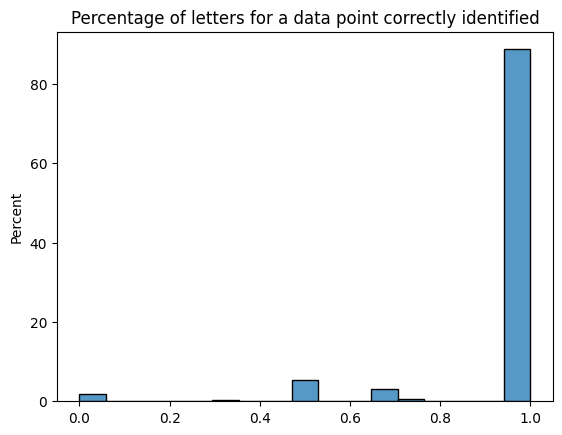

In [162]:
plt.figure(1)
sns.histplot(x  = np.sum((y_train_letter ==  y_train_cluster)*(y_train_letter == 1), axis = 1)/np.sum(y_train_letter,axis =1), stat = 'percent')
plt.title('Percentage of letters for a data point correctly identified')
plt.show()

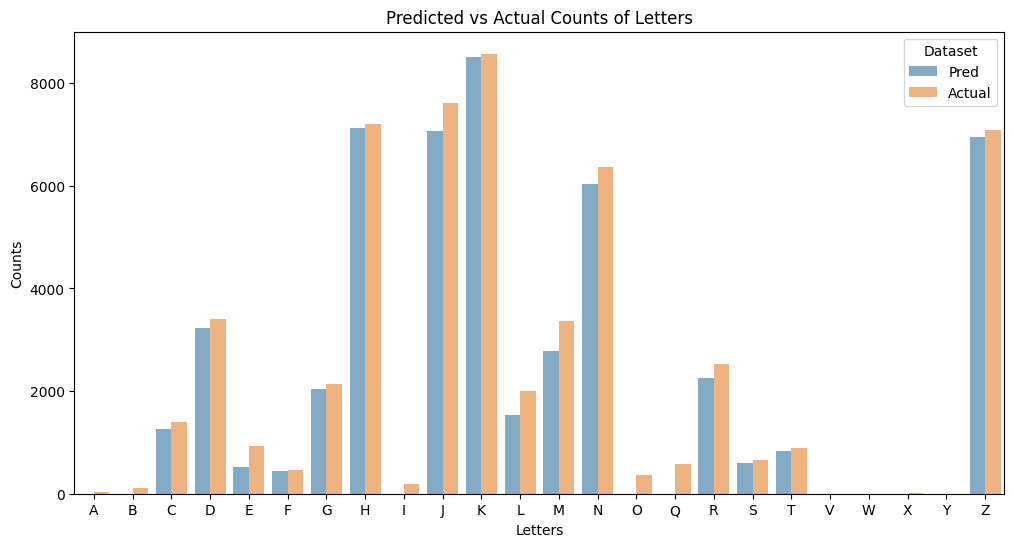

In [163]:
#carries the same assumption about the second stage
letter_pred = np.sum((y_train_letter == y_train_cluster)*(y_train_letter == 1),axis = 0)
letter_true = np.sum(y_train_letter,axis = 0)
data = {
    'Letter': [letter for letter in alphabets if letter!='P' and letter!='U'] * 2,
    'Count': np.concatenate([letter_pred, letter_true]),
    'Type': ['Pred'] * 24 + ['Actual'] * 24
}

# Create a DataFrame
df = pd.DataFrame(data)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Letter', y='Count', hue='Type', alpha=0.6)

# Customize the plot
plt.xlabel("Letters")
plt.ylabel("Counts")
plt.title("Predicted vs Actual Counts of Letters")
plt.legend(title="Dataset")
# plt.xticks(ticks = plt.xticks()[0],labels = [letter for letter in alphabets if letter != 'P' or letter!='U'])
# plt.legend(['Pred','Actual'])

In [164]:
## setting up the multiclass problem

In [93]:
from sklearn.preprocessing import OneHotEncoder

cluster_enc = OneHotEncoder(sparse_output = False)
y_cluster_train = cluster_enc.fit_transform(kmeans.predict(y_train_letter).reshape(-1,1))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [101]:
## train a multiclass classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42, verbose = 2)
classifier.fit(X_train, y_cluster_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42,
                       verbose=2)

In [122]:
n_test = 10000

In [165]:
y_cluster_onehot = classifier.predict(X_test[:n_test])

y_cluster_no = np.argmax(y_cluster_onehot,axis = 1)

y_cluster_rep = np.array([means_map[ind] for ind in y_cluster_no])

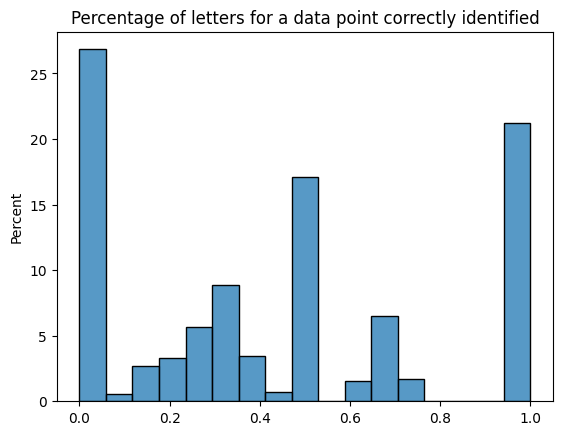

In [166]:
plt.figure(1)
plt.title('Percentage of letters for a data point correctly identified')
sns.histplot(x  = np.sum((y_test_letter[:n_test] ==  y_cluster_rep)*(y_test_letter[:n_test] == 1), axis = 1)/np.sum(y_test[:n_test],axis =1), stat = 'percent')
plt.show()

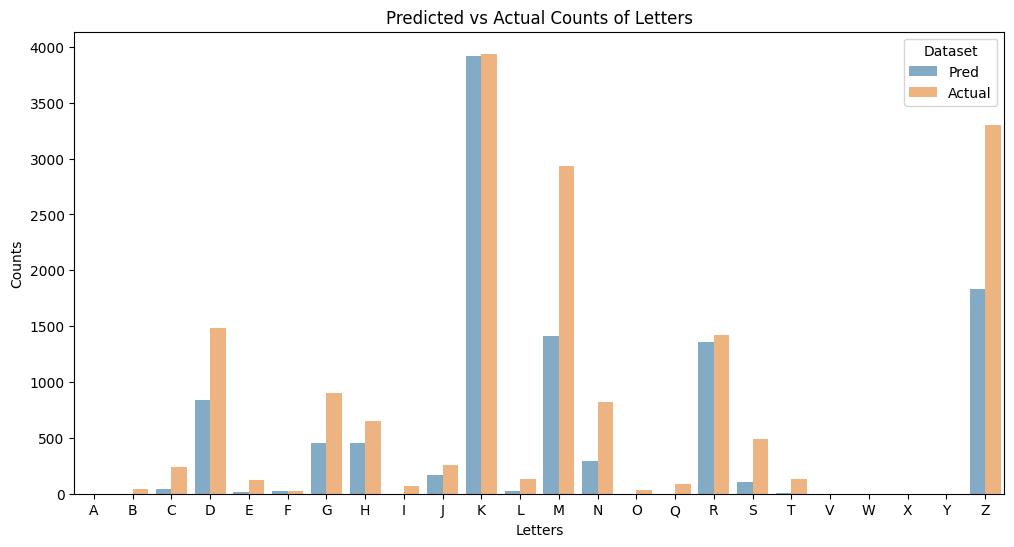

In [167]:
letter_pred = np.sum((y_test_letter[:n_test] ==  y_cluster_rep)*(y_test_letter[:n_test] == 1),axis = 0)
letter_true = np.sum(y_test_letter[:n_test],axis = 0)
data = {
    'Letter': [letter for letter in alphabets if letter!='P' and letter!='U'] * 2,
    'Count': np.concatenate([letter_pred, letter_true]),
    'Type': ['Pred'] * 24 + ['Actual'] * 24
}

# Create a DataFrame
df = pd.DataFrame(data)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Letter', y='Count', hue='Type', alpha=0.6)

# Customize the plot
plt.xlabel("Letters")
plt.ylabel("Counts")
plt.title("Predicted vs Actual Counts of Letters")
plt.legend(title="Dataset")

In [169]:
letter_presence_test = np.zeros_like(y_cluster_rep)
i = 0
for letter in alphabets:
    if letter == 'P' or letter == 'U':
        continue
    indices = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)] 
    letter_presence_test[:,i] = np.any(y_test[:n_test,indices],axis = 1)
    i +=1

In [170]:
true_predn_test = letter_presence_test*y_cluster_rep

In [171]:
print(f"Score is {fbeta_score(true_predn_test,letter_count_test,beta = 2,average = 'micro')}")
print(f"Hamming accuracy is {1-hamming_loss(true_predn_test,letter_count_test)}")
print(f"Jaccard Accuracy: {jaccard_score(true_predn_test,letter_count_test,average = 'samples')}")

Score is 0.8986750830127889
Hamming accuracy is 0.9743166666666667
Jaccard Accuracy: 0.6463533333333333


In [299]:
### 10 models for final predn
models ={}
indices_map = {}
labels_map = {} #key is cluster
for i,mean in tqdm(enumerate(means)):
    letters = mlb_letter.inverse_transform(mean.reshape(1,-1))[0]
    indices = [ind for ind,s in enumerate(mlabels) if s.startswith(letters)] 
    indices_map[i] = indices
    labels = [s for ind,s in enumerate(mlabels) if s.startswith(letters)] 
    labels_map[i] = labels
    train_data = X_train
    train_labels = y_train[:,indices]

    necessary_indices = np.sum(train_labels,axis = 1) !=0  #ranges from 5000-10000
    necessary_train_data = train_data[necessary_indices,:]
    necessary_train_labels = train_labels[necessary_indices,:]
    # print(f"Cluster {i} has {np.sum(necessary_indices)} data points")
    model = make_pipeline(PCA(n_components = 100),MultiOutputClassifier(RandomForestClassifier(n_estimators = 5,verbose = 1)))
    model.fit(train_data,train_labels)

    predictions = model.predict(X_test[:100])
    hamming = hamming_loss(y_test[:100],predictions)
    print(f"Hamming Loss: {hamming:.2f}")
    models[i] = model

0it [02:44, ?it/s]


KeyboardInterrupt: 

In [ ]:
def final_pred(X_test,pred_1,means,mlabels,models):
    pred_2 = np.zeros((X_test.shape[0],len(mlabels)))
    #pred_1 is y_cluster_no
    for i,mean in enumerate(means):
        letters = mlb_letter.inverse_transform(mean.reshape(1,-1))[0]
        indices = (pred_1 == i)
        if(np.sum(indices) ==0):
            continue
        test_data = X_test[indices,:]
        model_predn = np.zeros((np.sum(indices),len(mlabels)))
        model_predn[:,indices_map[i]] = models[i].predict(test_data)
        pred_2[indices,:] = model_predn
    return pred_2

In [ ]:
indices = np.arange(len(X_test))
np.random.shuffle(indices)
subsets_indices = np.array_split(indices, 10)

In [ ]:
gc.collect()

In [ ]:
scores = []
for sub in tqdm(subsets_indices[:5]):
    X_sub = X_test[sub]
    y_sub = y_test[sub]

    
    y_cluster_onehot_sub = classifier.predict(X_sub)
    y_cluster_no_sub = np.argmax(y_cluster_onehot_sub,axis = 1)
    
    pred_2 = final_pred(X_sub,y_cluster_no_sub,means,mlabels,models)
    scores.append(fbeta_score(pred_2,y_sub,beta = 2,average = 'micro'))

    del X_sub,y_sub,y_cluster_onehot_sub,y_cluster_no_sub,pred_2
    gc.collect()
print(scores)
print(np.mean(scores))

In [290]:
real_test = np.load('test_data.npy')

In [296]:
real_test[0]

array([ 0.7692894 , -0.30847618,  0.32729653, ...,  0.9859162 ,
       -0.86263525,  0.1871916 ], dtype=float32)

In [291]:
real_X_sub = real_test

y_cluster_onehot_sub = classifier.predict(real_X_sub)
y_cluster_no_sub = np.argmax(y_cluster_onehot_sub,axis = 1)

pred_2 = mlb.inverse_transform(final_pred(real_X_sub,y_cluster_no_sub,means,mlabels,models))

In [292]:
empty_pred = [i for i,pred in enumerate(pred_2) if pred == ()]

In [293]:
len(empty_pred)

69586

In [278]:
import csv
filename = "output_2.csv"

# Write the list of tuples to the CSV file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["id", "labels"])
    
    # Write each row with sequential ID
    for idx, labels in enumerate(pred_2, start=1):
        # Join labels with ';' and write to file
        writer.writerow([idx, ";".join(labels)])

print(f"Data saved to {filename}")

Data saved to output.csv


In [273]:
final_pred

[(1, ()),
 (2, ()),
 (3, ()),
 (4, ()),
 (5, ()),
 (6, ()),
 (7, ()),
 (8, ()),
 (9, ('S83.241A', 'S83.281A', 'S83.511A')),
 (10, ()),
 (11, ()),
 (12, ()),
 (13, ()),
 (14, ()),
 (15, ()),
 (16, ()),
 (17, ()),
 (18, ()),
 (19, ()),
 (20, ()),
 (21, ()),
 (22, ()),
 (23, ()),
 (24, ()),
 (25, ('G56.01',)),
 (26, ()),
 (27, ()),
 (28, ()),
 (29, ('M19.011', 'M75.41')),
 (30, ()),
 (31, ()),
 (32, ()),
 (33, ()),
 (34, ()),
 (35, ()),
 (36, ()),
 (37, ()),
 (38, ()),
 (39, ()),
 (40, ()),
 (41, ()),
 (42, ()),
 (43, ()),
 (44, ('G56.01',)),
 (45, ()),
 (46, ()),
 (47, ()),
 (48, ()),
 (49, ()),
 (50, ()),
 (51, ()),
 (52, ()),
 (53, ()),
 (54, ()),
 (55, ()),
 (56, ('S02.2XXA',)),
 (57, ()),
 (58, ()),
 (59, ()),
 (60, ()),
 (61, ()),
 (62, ()),
 (63, ()),
 (64, ()),
 (65, ()),
 (66, ()),
 (67, ()),
 (68, ()),
 (69, ()),
 (70, ()),
 (71, ()),
 (72, ()),
 (73, ()),
 (74, ()),
 (75, ()),
 (76, ()),
 (77, ()),
 (78, ()),
 (79, ()),
 (80, ()),
 (81, ()),
 (82, ('H02.831', 'H02.834')),
 (83,

In [ ]:
gc.collect()

In [218]:
pred_2 = final_pred(X_test[:n_test],y_test[:n_test],y_cluster_no,means,mlabels,models)

In [219]:
print(f"Score is {fbeta_score(pred_2,y_test[:n_test],beta = 2,average = 'micro')}")

Score is 0.6138510612194823


In [34]:
### A few comparisons ###

In [214]:
mlb.inverse_transform(pred_2[:5])

[(),
 ('D12.3', 'K63.5', 'Z12.11', 'Z86.010'),
 ('M25.551', 'M47.816', 'M48.061', 'M51.16', 'M54.50', 'M79.605'),
 ('K21.00', 'K44.9'),
 ()]

In [215]:
y_labels_test[:5]

[('H65.06', 'H65.23', 'H65.33', 'H69.83'),
 ('D12.2', 'D12.4', 'K57.30', 'K62.1', 'Z12.11', 'Z86.010'),
 ('M25.551', 'M25.561', 'M47.816', 'M48.061', 'M51.16', 'M54.50', 'M79.651'),
 ('K21.00', 'K22.70', 'K29.50', 'K31.89'),
 ('N84.1', 'N93.8', 'N93.9', 'Z30.430')]

In [20]:
# means[np.where((means>=0.1) * (means<=1.00))[0],np.where((means>=0.1) * (means<=1.00))[1]] = 1
# means[np.where(means!=1)] = 0